<a href="https://colab.research.google.com/github/WRD397/Practices/blob/main/fake_news_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [8]:
!pwd

/content


In [9]:
!ls

sample_data


In [10]:
import pandas as pd
import requests
import missingno as msno
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense


import nltk
from nltk.stem.porter import PorterStemmer 
import re
from nltk.corpus import stopwords

In [11]:
train = pd.read_csv('/gdrive/MyDrive/SelfProject/FakeNewsLSTM/data/train.csv')
test = pd.read_csv('/gdrive/MyDrive/SelfProject/FakeNewsLSTM/data/test.csv')

In [12]:
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [13]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


### Descriptive Analysis

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


<Axes: >

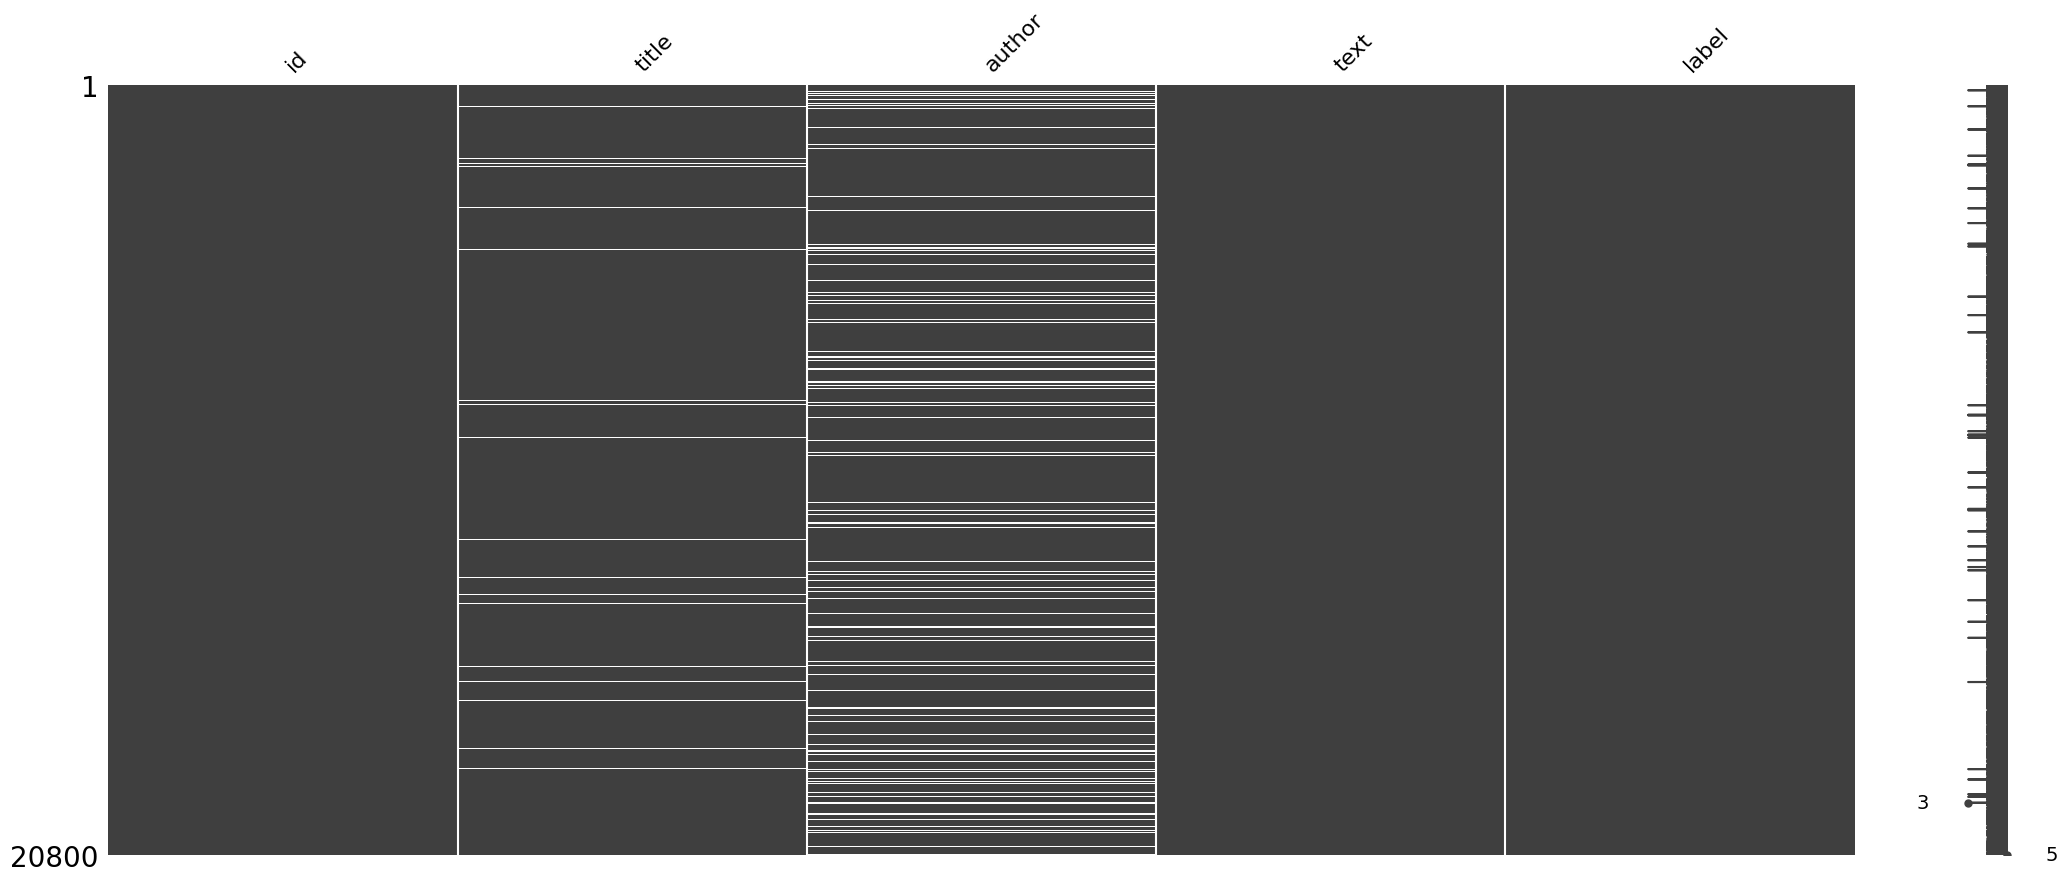

In [15]:
msno.matrix(train)

In [16]:
train.isnull().mean()

id        0.000000
title     0.026827
author    0.094087
text      0.001875
label     0.000000
dtype: float64

In [17]:
###Drop Nan Values
df = train.dropna()


In [18]:
## Get the Independent Features
X = df.drop('label',axis=1)

In [19]:
## Get the Dependent features
y=df['label']

In [20]:
X.shape

(18285, 4)

In [21]:
y.shape

(18285,)

## Data Preprocessing

In [22]:
X.head()

,id,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [23]:
X.drop(['id'], axis=1, inplace=True)
X.reset_index(drop=True, inplace=True)

In [24]:
X.head()

,title,author,text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [26]:
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [27]:
### Dataset Preprocessing
##stemming purpose
ps = PorterStemmer()
corpus = []
for i in range(0, len(X)):
    review = re.sub('[^a-zA-Z]', ' ', X['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [28]:
corpus[:10]

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri',
 'jacki mason hollywood would love trump bomb north korea lack tran bathroom exclus video breitbart',
 'beno hamon win french socialist parti presidenti nomin new york time',
 'back channel plan ukrain russia courtesi trump associ new york time',
 'obama organ action partner soro link indivis disrupt trump agenda',
 'bbc comedi sketch real housew isi caus outrag']

### OneHot Encoding

In [29]:
sum = ''
for item in corpus : 
  sum = sum + item + ' '
unique_words = set(sum.split(' '))

In [30]:
len(unique_words)

13932

In [31]:
voc_size = 15000
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
onehot_repr[:10]

[[42, 11658, 13797, 5250, 10405, 3167, 11333, 12980, 11466, 10343],
 [7482, 7463, 8817, 4505, 13495, 2215, 128],
 [4362, 1911, 13390, 2096],
 [29, 4118, 6610, 7313, 6422, 11824],
 [8223, 13495, 169, 4966, 1951, 3811, 13495, 7648, 8092, 11010],
 [12290,
  6390,
  10197,
  5860,
  13550,
  6151,
  5032,
  13091,
  5797,
  1641,
  790,
  5158,
  1834,
  8927,
  128],
 [6272, 3211, 9913, 1460, 13757, 856, 13903, 13327, 10202, 4882, 12885],
 [4861, 7899, 2961, 250, 7055, 2266, 6151, 2463, 10202, 4882, 12885],
 [12663, 42, 3965, 458, 2869, 4538, 4186, 13532, 6151, 11363],
 [5345, 9718, 2487, 11543, 10869, 1236, 1196, 5100]]

### Embedding Representation

lets look at the maximum length of an element

In [32]:
max([len(item) for item in onehot_repr])

47

In [33]:
max_length = 47
embedded_docs=pad_sequences(onehot_repr,padding='post',maxlen=max_length)
embedded_docs[:10]

array([[   42, 11658, 13797,  5250, 10405,  3167, 11333, 12980, 11466,
        10343,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0],
       [ 7482,  7463,  8817,  4505, 13495,  2215,   128,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0],
       [ 4362,  1911, 13390,  2096,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   

## Neural Network

In [34]:
## Creating model
embedding_vector_features=100 ##features representation
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_length))
model.add(LSTM(units = 200))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 47, 100)           1500000   
                                                                 
 lstm (LSTM)                 (None, 200)               240800    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 1,741,001
Trainable params: 1,741,001
Non-trainable params: 0
_________________________________________________________________


In [36]:
len(embedded_docs),y.shape

(18285, (18285,))

In [37]:
import numpy as np
from sklearn.model_selection import train_test_split


In [38]:
print(type(embedded_docs), type(y))

<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [39]:
X_final=embedded_docs
y_final=np.array(y)

In [40]:
X_final.shape,y_final.shape

((18285, 47), (18285,))

## Model Fitting

In [41]:
model.fit(X_final,y_final,validation_split = 0.33 ,epochs=10 , batch_size=64, verbose = 1)

Epoch 1/10
192/192 [==============================] - 27s 96ms/step - loss: 0.6658 - accuracy: 0.5952 - val_loss: 0.6799 - val_accuracy: 0.5806
Epoch 2/10
192/192 [==============================] - 6s 33ms/step - loss: 0.6739 - accuracy: 0.5896 - val_loss: 0.6749 - val_accuracy: 0.5964
Epoch 3/10
192/192 [==============================] - 3s 16ms/step - loss: 0.6692 - accuracy: 0.6012 - val_loss: 0.6681 - val_accuracy: 0.6002
Epoch 4/10
192/192 [==============================] - 3s 14ms/step - loss: 0.6425 - accuracy: 0.6470 - val_loss: 0.6474 - val_accuracy: 0.6469
Epoch 5/10
192/192 [==============================] - 3s 17ms/step - loss: 0.6403 - accuracy: 0.6548 - val_loss: 0.6872 - val_accuracy: 0.5644
Epoch 6/10
192/192 [==============================] - 2s 10ms/step - loss: 0.6854 - accuracy: 0.5678 - val_loss: 0.6852 - val_accuracy: 0.5644
Epoch 7/10
192/192 [==============================] - 3s 16ms/step - loss: 0.6851 - accuracy: 0.5678 - val_loss: 0.6858 - val_accuracy: 0.564

### Adding Dropout 

In [ ]:
from tensorflow.keras.layers import Dropout
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

### Performance Metrics And Accuracy

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
y_pred=np.where(y_pred > 0.6, 1,0) ##AUC ROC Curve

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_test,y_pred)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))